# The Automated Environmental Modeller

Created by: Darrell Leong \
Contact: Darrell@u.nus.edu

## Abstract
Scatter diagrams are typically available in the form of observation counts or normalised into frequencies. These classes of Python modules aim to perform long-term uncertainty modelling of sea state parameters in an automated fashion. The first class takes in the scatter diagram and fits model parameters using DNV recommended probability distributions, while the second class performs various analyses with the fitted model. These include extrapolating return period significant wave heights, and contouring of $N$-year conditions.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import scipy.optimize as optimization

## Input Dataset for Model Fitting

The input data into this tool is a form of a scatter diagram in the Excel spread sheet $\textbf{scatter.xlsx}$. The scatter table can be of any $N\times M$ size, normalised as frequencies or observation counts.

In [2]:
#%% Importing the dataset
df = pd.read_excel('scatter.xlsx')
Hs = list(df['Hs(m) / Tz (s)'])
Tz = list(df.columns.values)[1:]
scatter = df.to_numpy()[:,1:]

## Data Fitting Tool

In [3]:
# Environmental Analyst Object
class EnvFit:
    """
    Analyses scatter diagram to estimate long-term probabilistic characteristics.
    
    Attributes:
        Hs_hist (list(float)): PDF histogram of Hs.
        Hs_params (list(float)): Weibull parameters of Hs [alpha, beta, gamma].
        Hs_params_ls (list(float)): Weibull parameters of Hs [alpha, beta, gamma], least squares fitted.
        Tz_params (list(ndarray)): Log-normal subparameters of Tz [[a0, a1, a2], [b0, b1, b2]].
        mu_data (list(float)): Smoothed conditional log mean of Tz (plotted against Hs).
        sd_data (list(float)): Smoothed conditional log standard deviation of Tz (plotted against Hs).
        
    """
    
    def __init__(self, scatter, Hs, Tz):
        """
        Args:
            scatter (ndarray): Scatter grid, Hs by Tz.
            Hs (list(float)): Hs bins of scatter grid.
            Tz (list(float)): Tz bins of scatter grid.
            ErrTol (float): Error tolerance factor.
        
        """
        self.scatter = scatter
        self.Hs = Hs
        self.Tz = Tz
        
        self.Hs_params = self.hsfitting()
        self.Tz_params = self.tzfitting()
        
    def hsfitting(self):
        """
        Parameter fitting function for Hs.
        
        Returns:
            list(float): Weibull parameters of Hs [alpha, beta, gamma].
        """
        self.Hs_hist = np.sum(self.scatter, axis=1)
        
        #%% Simulate Data from Histogram
        self.N = int(1 / min(self.Hs_hist))
        Hs_hist_count = [int(h * self.N) for h in self.Hs_hist]
        i = 0
        data_h = []
        for h in self.Hs:
            for c in range(Hs_hist_count[i]):
                data_h.append(h)
            i+=1
        self.h_sd = np.std(data_h)
        
        # Least-squares fitting against Hs_hist to obtain gamma
        fitinit = stats.weibull_min.fit(data_h, loc = 0)
        x0 = [fitinit[0], fitinit[2], 0.95*min(data_h)]
        fun = lambda h, a, b, g: stats.weibull_min.pdf(h-g, a, 0., b)
        self.Hs_params_ls = optimization.curve_fit(fun, self.Hs, self.Hs_hist, p0=x0)[0]
        gamma = self.Hs_params_ls[2]
        
        # Fit alpha, beta using maximum liklihood
        weibull_params = stats.weibull_min.fit(data_h, loc=gamma)
        beta = weibull_params[0]
        alpha = weibull_params[2]
        
        return [alpha, beta, gamma]
    
    def tzfitting(self, Omega=0.2):
        
        # Simulate data from scatter
        HT_hist_count = [[int(s*self.N) for s in sj] for sj in scatter]
        i = 0
        data_ht = []
        for h in self.Hs:
            j = 0
            for t in self.Tz:
                for c in range(HT_hist_count[i][j]):
                    data_ht.append([h, t])
                j+=1
            i+=1
        
        fun_mu = lambda h, a0, a1, a2: a0 + a1*h**a2
        fun_sd = lambda h, b0, b1, b2: b0 + b1*np.exp(b2*h)
        
        self.mu_data = []
        self.sd_data = []
        for hi in self.Hs:
            psi = []
            num1 = []
            for [h, t] in data_ht:
                psij = np.exp(-(hi-h)**2 / (2*Omega*self.h_sd))
                num1.append(psij * np.log(t))
                psi.append(psij)
            den = np.sum(psi)
            mu_datai = np.sum(num1)/den
            
            num2 = []
            for [h, t], psij in zip(data_ht, psi):
                num2.append(psij * (np.log(t) - mu_datai)**2)
            sd_datai = np.sqrt(np.sum(num2)/den)
            
            self.mu_data.append(mu_datai)
            self.sd_data.append(sd_datai)
        
        # Least-squares fitting against smoothed conditional moments to model
        x0a = [0.7, 1.27, 0.131]
        x0b = [0.133, 0.0264, -0.191]
        Tz_params_a = optimization.curve_fit(fun_mu, self.Hs, self.mu_data, p0=x0a)[0]
        Tz_params_b = optimization.curve_fit(fun_sd, self.Hs[:-3], self.sd_data[:-3], 
                                             bounds=([0, 0, -np.inf], np.inf), p0=x0b)[0] # cropped off the tail
        
        return [Tz_params_a, Tz_params_b]

Obtain the environmental parameters by creating an instance of $\textbf{EnvFit()}$ by inputting the scatter data and the $H_s$ and $T_z$ arrays.

In [4]:
EnvFitInstance = EnvFit(scatter, Hs, Tz)
Hs_params = EnvFitInstance.Hs_params
Hs_hist = EnvFitInstance.Hs_hist

In [5]:
print('The Hs parameters are:')
print('alpha =', '%.3f' % Hs_params[0])
print('beta =', '%.3f' % Hs_params[1])
print('gamma =', '%.3f' % Hs_params[2])

a = EnvFitInstance.Tz_params[0]
b = EnvFitInstance.Tz_params[1]
print('The Tz parameters are:')
print('a0 =', '%.3f' % a[0])
print('a1 =', '%.3f' % a[1])
print('a2 =', '%.3f' % a[2])
print('b0 =', '%.4f' % b[0])
print('b1 =', '%.4f' % b[1])
print('b2 =', '%.4f' % b[2])

The Hs parameters are:
alpha = 3.411
beta = 1.668
gamma = 0.478
The Tz parameters are:
a0 = 1.641
a1 = 0.389
a2 = 0.288
b0 = 0.0965
b1 = 0.0761
b2 = -0.0771


## Results

Now let's look at the goodness of fit.

Text(0, 0.5, '$\\sigma \\left[ \\ln t | h\\right]$')

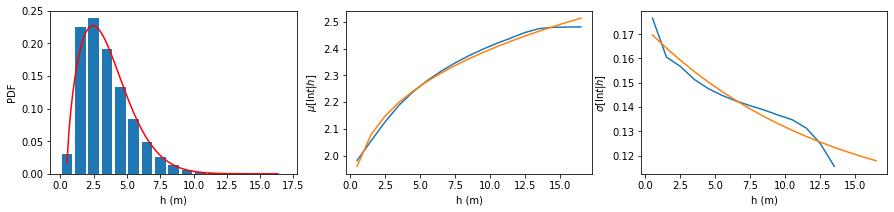

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
# Plot Hs histogram
axs[0].bar(Hs, Hs_hist)
h = np.arange(Hs[0], Hs[-1], (Hs[-1]-Hs[0])/100.0)
axs[0].plot(h, stats.weibull_min.pdf(h - Hs_params[2], Hs_params[1], 0., Hs_params[0]), color='red')
axs[0].set_xlabel('h (m)')
axs[0].set_ylabel('PDF')

# Plot fit of conditional moments

model_tsd = a[0]+ a[1]*np.power(Hs, a[2])
axs[1].plot(Hs, EnvFitInstance.mu_data)
axs[1].plot(Hs, model_tsd)
axs[1].set_xlabel('h (m)')
axs[1].set_ylabel(r'$\mu \left[ \ln t | h\right]$')

model_tsd = b[0]+ b[1]*np.exp(np.multiply(b[2], Hs))
axs[2].plot(Hs[:-3], EnvFitInstance.sd_data[:-3])
axs[2].plot(Hs, model_tsd)
axs[2].set_xlabel('h (m)')
axs[2].set_ylabel(r'$\sigma \left[ \ln t | h\right]$')

## Coming Up Next..

Using the above fitted model from the scatter diagram, the next class will perform automatic contour plotting by taking 2 additional inputs from the user:
- Return Period (years)
- Independence assumption (hours)